**Quora duplicates detection**

`Deadline: 2.12.2021 23:59 msk`

In this homework you will learn 1) how to build an LSTM-based siamese homework and search for the duplicates in quora question pairs dataset; 2) how to use Sentence BERT and fine-tune it for the same task. Then we will compare the final quality.

The homework is based on DeepLearning.AI materials.

**Part 1: Loading the dataset & Looking at it** (3 points)

For this task a well-known quora duplicate detection dataset will be used. We put the data to the "sample_data" folder in the current runtime (not the best option) but you are free to mount a google drive.

In [1]:
import os
import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from collections import defaultdict
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
PATH_TO_DATA = 'train'

In [3]:
data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))

As you can see the data consists of questions, and the indicator whether they are duplicate or not. Similar

In [4]:
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
data = data[~data['question1'].isna()]
data = data[~data['question2'].isna()]

In [6]:
# non-duplicate example
questions = data[data['is_duplicate'] == 0].loc[0]
print(f'Q1: {questions.question1}\nQ2: {questions.question2}')

Q1: What is the step by step guide to invest in share market in india?
Q2: What is the step by step guide to invest in share market?


In [7]:
# duplicate example
questions = data[data['is_duplicate'] == 1].loc[7]
print(f'Q1: {questions.question1}\nQ2: {questions.question2}')

Q1: How can I be a good geologist?
Q2: What should I do to be a great geologist?


Now the dataset is going to be divided into train and test parts for our analysis.

In [8]:
train, test = train_test_split(data, stratify=data['is_duplicate'], random_state=42)

**Task:** Do a little exploratory analysis. Find how many duplicates and non-duplicates are there in the train part and any other actions of your interest to better understand the data.

In [9]:
# your code here
train[train['is_duplicate'] == 1].count()

id              111947
qid1            111947
qid2            111947
question1       111947
question2       111947
is_duplicate    111947
dtype: int64

<AxesSubplot:xlabel='is_duplicate'>

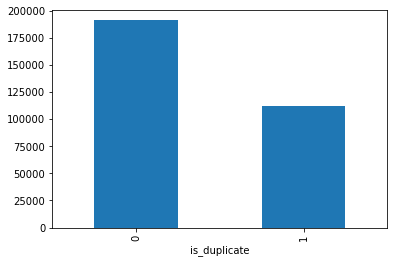

In [10]:
train.groupby("is_duplicate")['id'].count().plot.bar()

In [11]:
unique=len(set(list(train['qid1'])+list(train['qid2'])))
print ('Total number of  Unique Questions are: {}\n'.format(unique))

Total number of  Unique Questions are: 427623



In [12]:
len(list(train['qid1'])+list(train['qid2']))

606430

Now let's leave only positive examples to train the network. As we remember the negative examples for each of the anchors are taken from the same batch.

In [13]:
train_idx = train[train['is_duplicate'] == 1].id.tolist()
print(f'Number of training examples: {len(train_idx)}')

Number of training examples: 111947


In [14]:
q1_train_data = np.array(train.loc[train_idx, 'question1'])
q2_train_data = np.array(train.loc[train_idx, 'question2'])
q1_test_data = np.array(test['question1'])
q2_test_data = np.array(test['question2'])

q1_train = np.empty_like(q1_train_data)
q2_train = np.empty_like(q2_train_data)
q1_test = np.empty_like(q1_test_data)
q2_test = np.empty_like(q2_test_data)

y_test  = np.array(test['is_duplicate'])

In [15]:
q1_train_data[:5]

array(['Can a Gemini man and a Gemini woman have a successful relationship? Or are they incompatible?',
       'How can I delete my own question from Quora?',
       'Why are there still people who think that the Earth is flat?',
       'What should I do to concentrate more on my studies?',
       'How can one stop caring too much?'], dtype=object)

In [16]:
nltk.download('punkt')

vocab = defaultdict(lambda: 0)
vocab['<PAD>'] = 1

for idx in range(len(q1_train_data)):
    q1_train[idx] = nltk.word_tokenize(q1_train_data[idx])
    q2_train[idx] = nltk.word_tokenize(q2_train_data[idx])
    q = q1_train[idx] + q2_train[idx]
    for word in q:
        if word not in vocab:
            vocab[word] = len(vocab) + 1
print('Vocabulary size is: ', len(vocab))

[nltk_data] Downloading package punkt to /home/pk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vocabulary size is:  36377


In [17]:
# processing test

for idx in range(len(q1_test_data)): 
    q1_test[idx] = nltk.word_tokenize(q1_test_data[idx])
    q2_test[idx] = nltk.word_tokenize(q2_test_data[idx])

Converting the examples to tensors.

In [18]:
for i in range(len(q1_train)):
    q1_train[i] = [vocab[word] for word in q1_train[i]]
    q2_train[i] = [vocab[word] for word in q2_train[i]]

        
for i in range(len(q1_test)):
    q1_test[i] = [vocab[word] for word in q1_test[i]]
    q2_test[i] = [vocab[word] for word in q2_test[i]]

In [19]:
q1_train

array([list([2, 3, 4, 5, 6, 3, 4, 7, 8, 3, 9, 10, 11, 12, 13, 14, 15, 11]),
       list([23, 24, 25, 26, 27, 28, 29, 30, 31, 11]),
       list([36, 13, 37, 38, 39, 40, 41, 42, 18, 43, 17, 44, 11]), ...,
       list([200, 782, 344, 50, 25, 827, 472, 10832, 11]),
       list([692, 25, 4191, 55, 3922, 1163, 11, 36, 11]),
       list([524, 266, 162, 1274, 51, 58, 614, 11, 258, 853, 21, 468, 11])],
      dtype=object)

To check the model quality we are going to divide the train part into train and validation. 

In [20]:
q1_train, q1_val, q2_train, q2_val = train_test_split(q1_train, q2_train)

In [21]:
q1_val.shape

(27987,)

In [22]:
def data_generator(Q1, Q2, batch_size, pad=1, shuffle=True):
    """Generator function that yields batches of data

    Args:
        Q1 (list): List of transformed (to tensor) questions.
        Q2 (list): List of transformed (to tensor) questions.
        batch_size (int): Number of elements per batch.
        pad (int, optional): Pad character from the vocab. Defaults to 1.
        shuffle (bool, optional): If the batches should be randomnized or not. Defaults to True.
    Returns:
        tuple: Of the form (input1, input2) with types (numpy.ndarray, numpy.ndarray)
        NOTE: input1: inputs to your model [q1a, q2a, q3a, ...] i.e. (q1a,q1b) are duplicates
              input2: targets to your model [q1b, q2b,q3b, ...] i.e. (q1a,q2i) i!=a are not duplicates
    """

    input1 = []
    input2 = []
    idx = 0
    len_q = len(Q1)
    question_indexes = [*range(len_q)]
    
    if shuffle:
        rnd.shuffle(question_indexes)
    
    ### START CODE HERE (Replace instances of 'None' with your code) ###
    while True:
        if idx >= len_q:
            # if idx is greater than or equal to len_q, set idx accordingly 
            # (Hint: look at the instructions above)
            idx = 0
            # shuffle to get random batches if shuffle is set to True
            if shuffle:
                rnd.shuffle(question_indexes) 
        
        # get questions at the `question_indexes[idx]` position in Q1 and Q2
        q1 = Q1[question_indexes[idx]]
        q2 = Q2[question_indexes[idx]]
        
        # increment idx by 1
        idx += 1
        # append q1
        input1.append(q1)
        # append q2
        input2.append(q2)
        if len(input1) == batch_size:
            # determine max_len as the longest question in input1 & input 2
            # Hint: use the `max` function. 
            # take max of input1 & input2 and then max out of the two of them.
            max_len = max(max([len(i) for i in input1]),max([len(j) for j in input2]))
            # pad to power-of-2 (Hint: look at the instructions above)
            max_len = 2**int(np.ceil(np.log2(max_len)))
            b1 = [] 
            b2 = [] 
            for q1, q2 in zip(input1, input2):
                # add [pad] to q1 until it reaches max_len
                q1 = q1 + [pad] * (max_len - len(q1))
                # add [pad] to q2 until it reaches max_len
                q2 = q2 + [pad] * (max_len - len(q2))                
                # append q1
                b1.append(q1)
                # append q2
                b2.append(q2)
            # use b1 and b2
            yield np.array(b1), np.array(b2)
    ### END CODE HERE ###
            # reset the batches
            input1, input2 = [], []  # reset the batches

**Part 2: Buiding the siamese network** (10 points)

In [23]:
import trax
from trax import layers as tl
from trax.supervised import training

def Siamese(vocab_size=33000, d_model=128, mode='train'):
    """Returns a Siamese model.

    Args:
        vocab_size (int, optional): Length of the vocabulary. Defaults to len(vocab).
        d_model (int, optional): Depth of the model. Defaults to 128.
        mode (str, optional): 'train', 'eval' or 'predict', predict mode is for fast inference. Defaults to 'train'.

    Returns:
        A PyTorch Siamese model. 
    """

    def normalize(x):  # normalizes the vectors to have L2 norm 1
        return x / fastnp.sqrt(fastnp.sum(x * x, axis=-1, keepdims=True))
    
    # your code (Replace instances of 'None' with your code) ###
    q_processor = tl.Serial( #nn.Sequential(
        tl.Embedding(vocab_size, d_model), # Embedding layer
        tl.LSTM(d_model), # LSTM layer
        tl.Mean(axis=1), # Mean over columns
        tl.Fn("Normalize", normalize)  # Apply normalize function
    )
    
    # Try to run on Q1 and Q2 in parallel.
    model = tl.Parallel(q_processor, q_processor)
    return model


In [24]:
Siamese()

Parallel_in2_out2[
  Serial[
    Embedding_33000_128
    LSTM_128
    Mean
    Normalize
  ]
  Serial[
    Embedding_33000_128
    LSTM_128
    Mean
    Normalize
  ]
]

**Part 3: Measuring the quality** (10 points)

To calculate loss we will use `Triplet Loss`. The result of loss calculation in batch are values of similarity that should be the highest on the main diagonal (`np.diagonal`) and the second 



In [25]:
import trax.fastmath.numpy as fastnp

def TripletLossFn(v1, v2, margin=0.25):
    """Custom Loss function.

    Args:
       v1 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q1.
       v2 (numpy.ndarray): Array with dimension (batch_size, model_dimension) associated to Q2.
       margin (float, optional): Desired margin. Defaults to 0.25.

    Returns:
       jax.interpreters.xla.DeviceArray: Triplet Loss.
    """
    # use fastnp to take the dot product of the two batches (don't forget to transpose the second argument)
    scores = fastnp.dot(v1, v2.T)
    # calculate new batch size
    batch_size = len(scores)
    # use fastnp to grab all postive =diagonal= entries in =scores=
    positive = fastnp.diagonal(scores)  # the positive ones (duplicates)
    # multiply =fastjnp.eye(batch_size)= with 2.0 and subtract it out of =scores=
    negative_without_positive = scores - (fastnp.eye(batch_size) * 2.0)
    # take the row by row =max= of =negative_without_positive=. 
    # Hint: negative_without_positive.max(axis = [?])  
    closest_negative = fastnp.max(negative_without_positive, axis=1)
    # subtract =fastjnp.eye(batch_size)= out of 1.0 and do element-wise multiplication with =scores=
    negative_zero_on_duplicate = (1.0 - fastnp.eye(batch_size)) * scores
    # use =fastjnp.sum= on =negative_zero_on_duplicate= for =axis=1= and divide it by =(batch_size - 1)= 
    mean_negative = fastnp.sum(negative_zero_on_duplicate, axis=1)/(batch_size - 1)
    # compute =fastjnp.maximum= among 0.0 and =A=
    # A = subtract =positive= from =margin= and add =closest_negative= 
    triplet_loss1 = fastnp.maximum(0, margin - positive + closest_negative)
    # compute =fastjnp.maximum= among 0.0 and =B=
    # B = subtract =positive= from =margin= and add =mean_negative=
    triplet_loss2 = fastnp.maximum(0, (margin - positive) + mean_negative)
    # add the two losses together and take the =fastjnp.mean= of it
    triplet_loss = fastnp.mean(triplet_loss1 + triplet_loss2)
    return triplet_loss

In [26]:
v1 = np.array([[ 0.26726124,  0.53452248,  0.80178373],[-0.5178918 , -0.57543534, -0.63297887]])
v2 = np.array([[0.26726124, 0.53452248, 0.80178373],[0.5178918 , 0.57543534, 0.63297887]])
print("Triplet Loss:", TripletLossFn(v1,v2)) # expecting 0.5

Triplet Loss: 0.5


In [27]:
# make your function a layer
from functools import partial
def TripletLoss(margin=0.25):
    triplet_loss_fn = partial(TripletLossFn, margin=margin)
    return layers.Fn('TripletLoss', triplet_loss_fn)

**Part 4: Training the model** (10 points)

To train the model we should define cost function and optimizer and the model input.

In [28]:
batch_size = 256
# q1_train, q2_train, q1_val, q2_val 
train_generator = data_generator(q1_train, q2_train, batch_size, vocab['<PAD>'])
val_generator = data_generator(q1_val, q2_val, batch_size, vocab['<PAD>'])
print('train_Q1.shape ', q1_train.shape, q2_train.shape)
print('val_Q1.shape   ', q1_val.shape)

train_Q1.shape  (83960,) (83960,)
val_Q1.shape    (27987,)


In [29]:
from pathlib import Path
import trax
from trax import layers
import numpy
def train_model(Siamese, TripletLoss, train_generator, val_generator, output_dir="./models/",
                steps_per_checkpoint=100):
    """Training the Siamese Model

    Args:
       Siamese (function): Function that returns the Siamese model.
       TripletLoss (function): Function that defines the TripletLoss loss function.
       lr_schedule (function): Trax multifactor schedule function.
       train_generator (generator, optional): Training generator. Defaults to train_generator.
       val_generator (generator, optional): Validation generator. Defaults to val_generator.
       output_dir (str, optional): Path to save model to. Defaults to 'model/'.

    Returns:
       trax.supervised.training.Loop: Training loop for the model.
    """
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(400, 0.01)
    output_dir = Path(output_dir).expanduser()

    ### START CODE HERE (Replace instances of 'None' with your code) ###
    steps_per_checkpoint=100
    train_task = trax.supervised.training.TrainTask(
        labeled_data=train_generator,      
        loss_layer=TripletLoss(),        
        optimizer=trax.optimizers.Adam(0.01),          
        lr_schedule=lr_schedule, 
        n_steps_per_checkpoint=steps_per_checkpoint,
    )

    eval_task = trax.supervised.training.EvalTask(
        labeled_data=val_generator,       
        metrics=[TripletLoss()],         
    )

    ### END CODE HERE ###

    training_loop = trax.supervised.training.Loop(Siamese(),
                                                  train_task,
                                                  eval_tasks=[eval_task],
                                                  output_dir=output_dir)

    return training_loop

In [30]:
import random as rnd

# %%time
train_steps = 5
training_loop = train_model(Siamese, TripletLoss, train_generator, val_generator)
training_loop.run(train_steps)

/home/pk/anaconda3/lib/python3.8/site-packages/jax/_src/lib/xla_bridge.py:412: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [31]:
model = Siamese()
model.init_from_file('models/model.pkl.gz')

(((array([[ 0.11875313,  0.05593207, -0.07987386, ...,  0.01123042,
            0.13157398,  0.05508289],
          [ 0.08577887, -0.08110738, -0.68326616, ..., -0.49868444,
            0.01074426,  0.0485232 ],
          [ 0.04366594,  0.11449299, -0.13759665, ...,  0.2349906 ,
           -0.06320382,  0.14746805],
          ...,
          [-0.07580012,  0.1814747 , -0.14015569, ..., -0.0378515 ,
           -0.08749231, -0.13799816],
          [-0.14550471,  0.03182001, -0.12691548, ...,  0.04782498,
           -0.1356529 , -0.04355934],
          [-0.08534821, -0.20270443,  0.01745207, ..., -0.33479705,
           -0.28703666,  0.57965493]], dtype=float32),
   (((), ((), ())),
    ((array([[-0.00700635, -0.81279695, -0.1969731 , ...,  0.33134758,
              -0.01820136,  0.09090405],
             [-0.09393045, -0.14250134,  0.03360443, ..., -0.26035592,
               0.0903319 ,  0.07371619],
             [-0.0230589 , -0.1425545 ,  0.05566799, ..., -0.10225294,
              -0.

In [111]:
def classify(test_Q1, test_Q2, y, threshold, model, vocab, data_generator=data_generator, batch_size=64):
    """Function to test the accuracy of the model.

    Args:
        test_Q1 (numpy.ndarray): Array of Q1 questions.
        test_Q2 (numpy.ndarray): Array of Q2 questions.
        y (numpy.ndarray): Array of actual target.
        threshold (float): Desired threshold.
        model: The Siamese model.
        vocab (collections.defaultdict): The vocabulary used.
        data_generator (function): Data generator function. Defaults to data_generator.
        batch_size (int, optional): Size of the batches. Defaults to 64.

    Returns:
        float: Accuracy of the model.
    """    
    
    
    accuracy1, TP1, TN1, FN1, FP1 = 0,0,0,0,0
    ### START CODE HERE (Replace 'None' with your code) ###
    for i in range(0, len(test_Q1), batch_size):
        # Call the data generator (built in Ex 01) with shuffle= None
        # use batch size chuncks of questions as Q1 & Q2 arguments of the data generator. e.g x[i:i + batch_size]
        # Hint: use `vocab['<PAD>']` for the `pad` argument of the data generator
        q1, q2 = next(data_generator(test_Q1[i: i + batch_size], 
                                     test_Q2[i: i+batch_size], batch_size, 
                                     pad=vocab['<PAD>'], shuffle=False))

        # use batch size chuncks of actual output targets (same syntax as example above)
        if i+batch_size < len(y):
            y_test = y[i: i + batch_size]
#         else: 
#             y_test = y[i:]
        # Call the model    
            v1, v2 = model((q1,q2))

            for j in range(batch_size):
                # take dot product to compute cos similarity of each pair of entries, v1[j], v2[j]
                # don't forget to transpose the second argument
                d = fastnp.dot(v1[j],v2[j].T)
                # is d greater than the threshold?
                res = int(d > threshold)
                correct = res == y_test[j]
                if res:
                    if correct:
                        TP1+=1
                    else:
                        FP1+=1
                else:
                    if correct:
                        TN1+=1
                    else:
                        FN1+=1
                # increment accurancy if y_test is equal `res`
                accuracy1 += int(correct)
              
    # compute accuracy using accuracy and total length of test questions
    accuracy1 = accuracy1 / len(test_Q1)
    ### END CODE HERE ###
    
    return accuracy1, TP1, TN1, FN1, FP1 

In [112]:
accuracy,  TP, TN, FN, FP  = classify(q1_test,q2_test, y_test, 0.7, model, vocab, batch_size = 256) 
# print("Accuracy", accuracy)

In [99]:
accuracy

DeviceArray(0.7373654, dtype=float32)

In [113]:
accuracy

0.7373654424568624

In [114]:
TP, TN, FN, FP

(31738, 42789, 5489, 20848)

In [115]:
(TP+TN)/(TP+TN+FN+FP)

0.7388860247461929

#### Accuracy of the model is 0.737

In [35]:
def predict(question1, question2, threshold, model, vocab, data_generator=data_generator):
  
    q1 = nltk.word_tokenize(question1) 
    q2 = nltk.word_tokenize(question2)  
    Q1, Q2 = [], []
    for word in q1: 
        Q1 += [vocab[word]]
    for word in q2: 
        Q2 += [vocab[word]]

    Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab['<PAD>']))
    v1, v2 = model((Q1,Q2))

    d = fastnp.dot(v1, v2.T)
    res = d > threshold
    
    
    print("Q1  = ", Q1, "\nQ2  = ", Q2)
    print("Similarity   = ", d)
    print("res = ", res)

    return res

In [36]:
question1 = "When will I see you?"
question2 = "When can I see you again?"

In [37]:
predict(question1 , question2, 0.8, model, vocab)

Q1  =  [[598  97  25 180  91  11   1   1]] 
Q2  =  [[ 598   24   25  180   91 2029   11    1]]
Similarity   =  [[0.9333575]]
res =  [[ True]]


DeviceArray([[ True]], dtype=bool)

**Part 5: Sentence-BERT** (7 points)

**Task:** Get acquinted with Sentence-BERT model and work with that model to get results on quora dataset.  

https://arxiv.org/abs/1908.10084
 
https://huggingface.co/sentence-transformers 

In [38]:
# Importing SentenceTransformer and cosine similarty
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

# distilbert model is used
model_bert = SentenceTransformer('sentence-transformers/quora-distilbert-base')

In [39]:
model_bert

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: DistilBertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [41]:
# embedding question1 list using distilbert model
encoded_q1 = model_bert.encode(test['question1'].to_list())

In [42]:
# embedding question2 list using distilbert model

encoded_q2 = model_bert.encode(test['question2'].to_list())

In [70]:
# Function to caluclate accuracy of bert model
def accurecy_bert(q1, q2, y, threshold):
    accuracy_bert = 0
    for i in range(0, len(test)):

        d = 1-cosine(q1[i],q2[i])
        res = d > threshold
        accuracy_bert += (y[i] == res)
    accuracy_bert = accuracy_bert / len(y)
    return accuracy_bert

In [71]:
accurecy_bert(encoded_q1, encoded_q2, y_test, 0.7)

0.7969566249802121

In [102]:
# Function to caluclate accuracy of bert model
def classification_bert(q1, q2, y, threshold):
    TP, TN, FP, FN = 0,0,0,0
    accuracy_bert = 0
    for i in range(0, len(test)):

        d = 1-cosine(q1[i],q2[i])
        res = d > threshold
        accuracy_bert += (y[i] == res)
        if y[i]==res==1:
            TP+=1
        elif y[i]==res==0:
            TN+=1
        elif y[i]==1 and res ==0:
            FN+=1
        elif y[i]==0 and res ==1:
            FP+=1
            
    accuracy_bert = accuracy_bert / len(y)
    return accuracy_bert, TP,TN,FN,FP

In [103]:
accuracy, TP, TN, FN, FP = classification_bert(encoded_q1, encoded_q2, y_test, 0.7)

In [104]:
accuracy

0.7969566249802121

In [105]:
TP, TN, FN, FP

(36826, 43724, 490, 20032)

In [106]:
(TP+TN)/(TP+TN+FN+FP)

0.7969566249802121

### Accuracy using distilbert model is 0.797.
Accuracy of the model can be increased by fine tuning the model.

**Task** Compare the results of LSTM-based model and Sentence BERT. Look at the particular examples and make conclusions. Write down your thoughts.

In [46]:
# your code & results description here


In [50]:
# predicting the similarity between question using lstm Siamese model
def predict_lstm(question1, question2, threshold, model, vocab, data_generator=data_generator, verbose=False):
    q1 = nltk.word_tokenize(question1)  
    q2 = nltk.word_tokenize(question2)  
    Q1, Q2 = [], []
    for word in q1:   
        Q1 += [vocab[word]]
    for word in q2:  
        Q2 += [vocab[word]]
        
    Q1, Q2 = next(data_generator([Q1], [Q2], 1, vocab['<PAD>']))
    v1, v2 = model([Q1,Q2])

    d = fastnp.dot(v1, v2.T)
    res = d > threshold
    
    print('question1:' ,question1)
    print('question2:' ,question2)    
    print("Similarity:", d)
    print('Is similar:', res)

    return res

In [64]:
# sample test question which are not similar
question1 = 'I am visiting Sri Lanka soonfor 9 days, how can I pick up Sri Lankan girls and have fun?'

question2 = 'Do Indians hate Sri Lankans?'

In [82]:
predict(question1 , question2, 0.7, model, vocab)

question1: I am visiting Sri Lanka soonfor 9 days, how can I pick up Sri Lankan girls and have fun?
question2: Do Indians hate Sri Lankans?
Similarity: [[0.15066601]]
Is similar: [[False]]


DeviceArray([[False]], dtype=bool)

In [72]:
# predicting the similarity between question using distilbert model

def predict_bert(question1, question2, threshold, model):
    q1, q2 = model.encode([question1, question2])
    d = 1-cosine(q1, q2)
    res = d > threshold
    
    print('question1:' ,question1)
    print('question2:' ,question2)    
    print("Similarity:", d)
    print('Is similar:', res)
    
    return res
    

In [73]:
predict_bert(question1, question2, 0.7, model_bert)

question1: I am visiting Sri Lanka soonfor 9 days, how can I pick up Sri Lankan girls and have fun?
question2: Do Indians hate Sri Lankans?
Similarity: 0.3482406437397003
Is similar: False


False

In [81]:
data.question2[2012]

'The weak and ignorance is not an impediment to survival, arrogance is? (in Japanese)'

In [84]:
# sample test question which are similar

question3 = 'The weak and ignorance is not an impediment to survival, arrogance is?'
question4= 'The weak and ignorance is not an impediment to survival, arrogance is? (in Japanese)'


In [85]:
predict(question3 , question4, 0.7, model, vocab)

question1: The weak and ignorance is not an impediment to survival, arrogance is?
question2: The weak and ignorance is not an impediment to survival, arrogance is? (in Japanese)
Similarity: [[0.79751545]]
Is similar: [[ True]]


DeviceArray([[ True]], dtype=bool)

In [86]:
predict_bert(question3, question4, 0.7, model_bert)

question1: The weak and ignorance is not an impediment to survival, arrogance is?
question2: The weak and ignorance is not an impediment to survival, arrogance is? (in Japanese)
Similarity: 0.985177218914032
Is similar: True


True

Based on the predictions and accuracy both models are working with nearly similar accuracy, distilbert have abitof upper hand. But according to the classification report. Both Siamese Lstm and Distilbert model have alot of flase positive cases. 